In [3]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from dataset import LinearDynamicalDataset, WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from model import GPTConfig, GPT
import tqdm
import argparse

In [4]:
# Overall settings
out_dir = "trained_models"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 32 # 256
fixed_system = True # Are we testing on a fixed system?
model_seed = None

# Compute settings
cuda_device = "cuda:2"
no_cuda = False
threads = 32
compile = True

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [6]:
# Create out dir
out_dir = Path(out_dir)
#exp_data = torch.load(out_dir/"ckpt_lin.pt") # trained on linear models!
#exp_data = torch.load(out_dir/"ckpt_small_wh_last.pt")
#exp_data = torch.load(out_dir/"ckpt_small_wh.pt",  map_location=device)
exp_data = torch.load(out_dir/"ckpt_big_wh.pt", map_location=device)
#exp_data = torch.load(out_dir/"ckpt_small_wh_adapt_last.pt")
cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None

In [7]:
seq_len = cfg.seq_len
nx = cfg.nx
model_seed = cfg.seed if model_seed is None else model_seed 

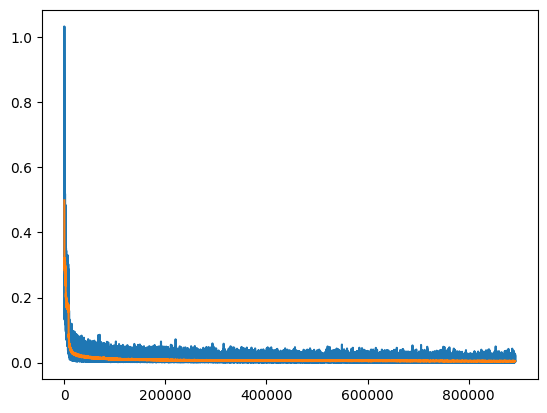

In [8]:
loss_smooth = pd.Series(exp_data["LOSS"]).rolling(100).mean()
#fig = go.Figure()
#fig.add_trace(go.Scatter(y=exp_data["LOSS"], name="TRAINING LOSS", line_color="black"))
#fig.add_trace(go.Scatter(y=loss_smooth, name="TRAINING LOSS SMOOTH", line_color="blue"))
#fig.add_trace(go.Scatter(x=np.arange(1, len(exp_data["LOSS_VAL"])+1)*2000,
#                         y=exp_data["LOSS_VAL"], name="VAL LOSS", line_color="red")
#             )
#fig.show()

plt.figure()
plt.plot(exp_data["LOSS"], label="TRAINING_LOSS")
plt.plot(loss_smooth, label="TRAINING_LOSS_SMOOTH");

In [10]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.44M


In [13]:
# Create data loader
test_ds = WHDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len,
                    system_seed=cfg.seed if fixed_system else None,
                    data_seed=None, fixed_system=fixed_system)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=threads)

In [14]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
with torch.no_grad():
    batch_y_pred, loss = model(batch_u, batch_y)

In [ ]:
# Call model in simulation from a certain time step!
sim_start = 400 #seq_len//2#500
batch_y_sim = torch.zeros_like(batch_y)
batch_y_sim[:, :sim_start, :] = batch_y[:, :sim_start, :]
with torch.no_grad():
    for idx in range(sim_start, seq_len):
        batch_y_t, _ = model(batch_u[:, :idx, :], batch_y_sim[:, :idx, :], compute_loss=False)
        batch_y_sim[:, [idx], :] = batch_y_t

In [ ]:
batch_y_sim = batch_y_sim.to("cpu").detach().numpy()
batch_y_pred = batch_y_pred.to("cpu").detach().numpy()
batch_y = batch_y.to("cpu").detach().numpy()
batch_u = batch_u.to("cpu").detach().numpy()

In [ ]:
batch_y_target = batch_y[:, 1:, :] # target @ time k: y_{k+1}
batch_y_pred = batch_y_pred[:, :-1, :] # prediction @ time k: y_{k+1|k}
batch_y_sim = batch_y_sim[:, 1:, :] # simulation @ time k: y_{k+1|k}
batch_y_pred_dummy = batch_y[:, :-1, :] # dummy estimator: y_{k+1} \approx y_{k}
batch_pred_err = batch_y_target - batch_y_pred
batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy
batch_sim_err = batch_y_target - batch_y_sim

In [ ]:
plt.figure()
plt.title("RMSE")
idx = 0
plt.plot(batch_y_target[idx], 'k', label="True")
plt.plot(batch_y_pred[idx], 'b', label="Pred")
plt.plot(batch_y_sim[idx], 'g', label="Sim")
#plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
plt.plot(batch_pred_err[idx], 'r', label="Pred_Err")
plt.plot(batch_sim_err[idx], 'm', label="Sim_Err")
plt.axvline(x=sim_start, color="black")
#plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
plt.legend()
#plt.xlim([0, 600]);

In [ ]:
#plt.plot(batch_pred_err_dummy.squeeze(-1).T, "b", alpha=0.4);
plt.plot(batch_pred_err.squeeze(-1).T, "r", alpha=0.2);
plt.plot(batch_sim_err.squeeze(-1).T, "m", alpha=0.2);

In [ ]:
from torchid import metrics
skip = sim_start
rmse_pred = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)
rmse_sim = metrics.rmse(batch_y_target[:, skip:, :], batch_y_sim[:, skip:, :], time_axis=1)
rmse_dummy = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred_dummy[:, skip:, :], time_axis=1)

In [ ]:
plt.figure()
plt.title("RMSE")
plt.hist(rmse_dummy, color="blue", label="dummy");
plt.hist(rmse_pred, color="red", label="pred");
plt.hist(rmse_sim, color="magenta", label="sim");
plt.legend();

In [ ]:
print(f"{rmse_pred.mean()=:.3f}, {rmse_sim.mean()=:.3f}, {rmse_dummy.mean()=:.3f}, {loss=:.3f}")